In [0]:
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from PIL import Image
from keras import backend as K
from keras.preprocessing.image import img_to_array, load_img

In [0]:
style_image_path = 'images/scream.jpeg'
content_image_path = 'images/tower.jpeg'

target_dim = 512

style_image_original = Image.open(style_image_path)
content_image_original = Image.open(content_image_path)
content_image = content_image_original.resize((target_dim, target_dim))
style_image = style_image_original.resize((target_dim, target_dim))

In [0]:
content_array = np.asarray(content_image, dtype = 'float32')
style_array = np.asarray(style_image, dtype = 'float32')
content_array = np.expand_dims(content_array, axis = 0)
style_array = np.expand_dims(style_array, axis = 0)

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [13]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, target_dim, target_dim, 3))

print(style_array.shape)
print(content_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
input_tensor = K.concatenate([content_image, style_image, combination_image], axis = 0)

In [0]:
model = VGG16(input_tensor = input_tensor, weights = 'imagenet', include_top = False)

In [16]:
content_weight = 0.03
style_weight = 1
total_variation_weight = 1.0

loss = K.variable(0.)

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [17]:
def content_loss(content, combination):
    return K.sum(K.square(content - combination))

layer_features = layers['block4_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight*content_loss(content_image_features, combination_features)

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

In [0]:

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = target_dim*target_dim
    return K.sum(K.square(S - C))/ (4.*(channels ** 2) * (size ** 2))

In [0]:
feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']

In [0]:
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight/len(feature_layers)) * sl

In [0]:
height = target_dim
width = target_dim
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_values = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_values, grad_values

In [0]:
class Evaluator(object):
    
    def __init__(self):
        self.loss_values = None
        self.grad_values = None
    
    def loss(self, x):
        assert self.loss_values is None
        loss_values, grad_values = eval_loss_and_grads(x)
        self.loss_values = loss_values
        self.grad_values = grad_values
        return self.loss_values

    def grads(self, x):
        assert self.loss_values is not None
        grad_values = np.copy(self.grad_values)
        self.loss_values = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [25]:
import time
from scipy.optimize import fmin_l_bfgs_b

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 25

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

print("Completed")

Start of iteration 0
Current loss value: 4960995300.0
Iteration 0 completed in 20s
Start of iteration 1
Current loss value: 2166231000.0
Iteration 1 completed in 16s
Start of iteration 2
Current loss value: 1708542300.0
Iteration 2 completed in 16s
Start of iteration 3
Current loss value: 1530741500.0
Iteration 3 completed in 16s
Start of iteration 4
Current loss value: 1433215000.0
Iteration 4 completed in 16s
Start of iteration 5
Current loss value: 1372756200.0
Iteration 5 completed in 16s
Start of iteration 6
Current loss value: 1330922000.0
Iteration 6 completed in 16s
Start of iteration 7
Current loss value: 1299917700.0
Iteration 7 completed in 16s
Start of iteration 8
Current loss value: 1275221800.0
Iteration 8 completed in 16s
Start of iteration 9
Current loss value: 1255879000.0
Iteration 9 completed in 16s
Start of iteration 10
Current loss value: 1239297000.0
Iteration 10 completed in 16s
Start of iteration 11
Current loss value: 1225689100.0
Iteration 11 completed in 16s


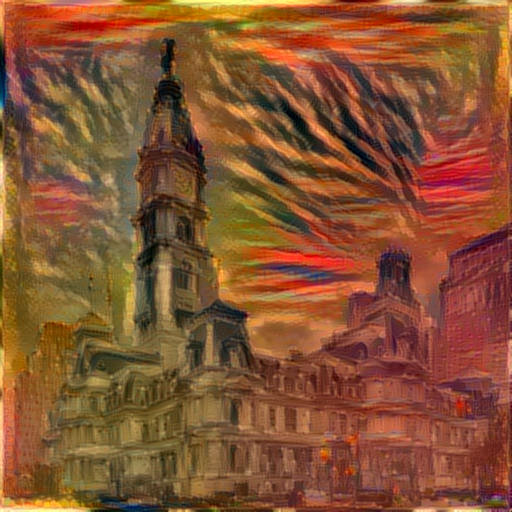

In [26]:
from scipy.misc import imsave
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x, 'RGB')

In [0]:
img = Image.fromarray(x, 'RGB')
img.save('images/tower5.jpeg')